In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from PIL import Image
from tensorflow.keras.utils import img_to_array, array_to_img

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_train.shape, x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32))) for im in x_test])
x_train.shape, x_test.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
resnet50 = tf.keras.applications.ResNet50(include_top=False, input_shape=(32, 32, 3), classes=10)

for each_layer in resnet50.layers:
        each_layer.trainable=False

x = tf.keras.layers.Flatten()(resnet50.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet50.input, outputs=predictions) 

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.fit(x_train, y_train, epochs=20, batch_size=256, validation_data=(x_test, y_test), shuffle=True)


Epoch 1/20
235/235 [==============================] - 11s 35ms/step - loss: 0.6078 - accuracy: 0.8025 - val_loss: 0.4718 - val_accuracy: 0.8247
Epoch 2/20
235/235 [==============================] - 7s 31ms/step - loss: 0.3877 - accuracy: 0.8576 - val_loss: 0.4172 - val_accuracy: 0.8473
Epoch 3/20
235/235 [==============================] - 7s 32ms/step - loss: 0.3401 - accuracy: 0.8735 - val_loss: 0.4119 - val_accuracy: 0.8542
Epoch 4/20
235/235 [==============================] - 7s 30ms/step - loss: 0.3075 - accuracy: 0.8852 - val_loss: 0.4013 - val_accuracy: 0.8564
Epoch 5/20
235/235 [==============================] - 7s 31ms/step - loss: 0.2796 - accuracy: 0.8958 - val_loss: 0.3899 - val_accuracy: 0.8595
Epoch 6/20
235/235 [==============================] - 7s 30ms/step - loss: 0.2616 - accuracy: 0.9017 - val_loss: 0.4107 - val_accuracy: 0.8580
Epoch 7/20
235/235 [==============================] - 7s 29ms/step - loss: 0.2425 - accuracy: 0.9088 - val_loss: 0.4061 - val_accuracy: 0.864

На базі Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist.

In [ ]:
from keras.layers import concatenate

img_a_in = tf.keras.layers.Input(shape = train_images.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = train_images.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 16)           336         ['merge_features[1][0

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [ ]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 84ms/step


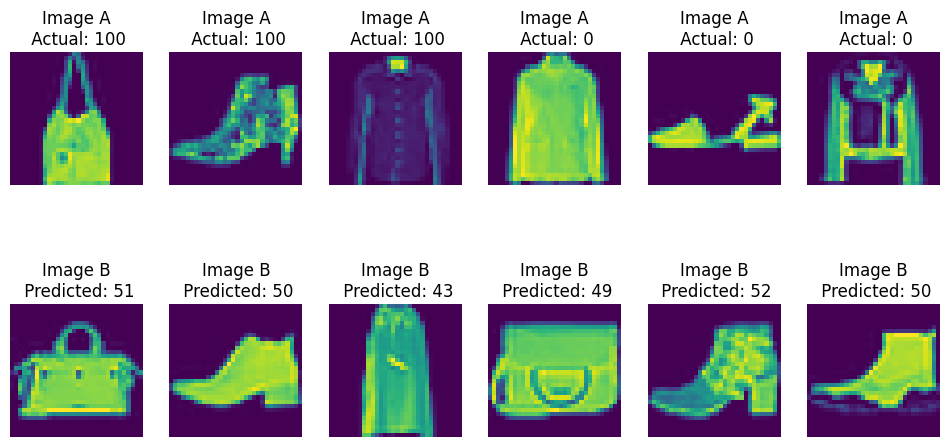

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)

loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = True)

1/1 [==============================] - 0s 21ms/step
Epoch 1/4
500/500 [==============================] - 86s 168ms/step - loss: 0.4565 - mae: 0.3422 - val_loss: 0.3399 - val_mae: 0.2403
Epoch 2/4
500/500 [==============================] - 92s 185ms/step - loss: 0.1135 - mae: 0.0889 - val_loss: 0.3400 - val_mae: 0.1467
Epoch 3/4
500/500 [==============================] - 100s 201ms/step - loss: 0.0707 - mae: 0.0455 - val_loss: 0.3599 - val_mae: 0.1312
Epoch 4/4
500/500 [==============================] - 106s 212ms/step - loss: 0.0656 - mae: 0.0379 - val_loss: 0.3595 - val_mae: 0.1250


1/1 [==============================] - 0s 77ms/step


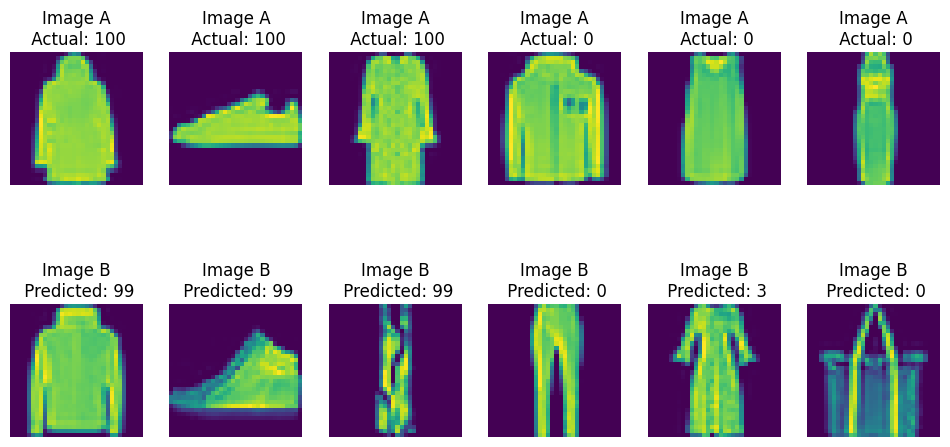

In [ ]:
_ = show_model_output()

Візуалізувати отримані результати t-SNE.

In [ ]:

%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=256)

tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

40/40 [==============================] - 1s 25ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.550s
[t-SNE] Iteration 50: error = 79.1515961, gradient

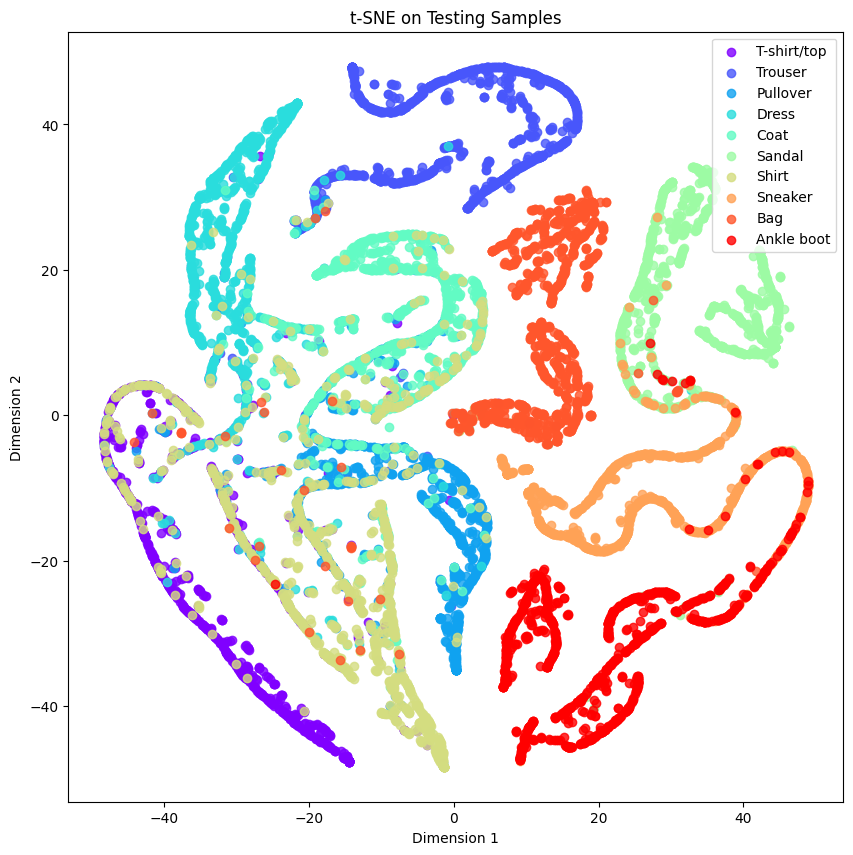

In [ ]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)